# Esercizio 5 - Topic Modelling

L'obiettivo è trovare i topic principali di un corpus di testi.  
Come corpus utilizzo i testi di 4 pagine di Wikipedia relative agli stessi 4 argomenti trattati nell'esercizio 4:
- Lebanon
- Racing bicycle
- Labrador retriever
- Indie rock

Questi testi li unisco in un unica lista che, dopo la fase di preprocessing, sarà il corpus su cui allenare il modello scelto.  
Il modello scelto è **LDA** (Latent Dirichlet Allocation), fornito dalla libreria *Gensim*.

In [78]:
import wikipediaapi
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

## Creo i testi di riferimento

Scarico da Wikipedia i testi delle 4 pagine e li unisco in una lista. Ogni elemento della lista è una stringa che rappresenta il testo di una pagina Wikipedia.

In [79]:
# Try wiki api
wiki_wiki = wikipediaapi.Wikipedia('en')

lebanon_page = wiki_wiki.page('Lebanon')
bike_page = wiki_wiki.page('Racing bicycle')
labrador_page = wiki_wiki.page('Labrador retriever')
indie_page = wiki_wiki.page('Indie rock')

lebanon_text = lebanon_page.text
bike_text = bike_page.text
labrador_text = labrador_page.text
indie_text = indie_page.text

docs = [lebanon_text, bike_text, labrador_text, indie_text]

## Preprocessing dei documenti

Tramite la libreria *nltk* eseguo il preprocessing dei documenti.  
Dopodichè con la funzione `gensim.corpora.Dictionary()` creo un dizionario che associa ad ogni parola un indice.  
Da questo dizionario rimuovo le parole che appaiono in più del 50% dei documenti.  
Infine costruisco una lista di documenti, dove ogni documento è rappresentato come una bag of words.

In [80]:
# Tokenize, remove stopwords, lemmatize a list of documents
tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess(docs):
    prep = docs.copy()
    for i in range(len(docs)):
        prep[i] = prep[i].lower()
        prep[i] = tokenizer.tokenize(prep[i])
        prep[i] = [word for word in prep[i] if word not in stop_words]
        prep[i] = [lemmatizer.lemmatize(word) for word in prep[i]]
        # Remove single characters
        prep[i] = [word for word in prep[i] if len(word) > 1]
        # Remove word if is a number
        prep[i] = [word for word in prep[i] if not word.isnumeric()]
    return prep

preprocessed_docs = preprocess(docs)

# Create dictionary
dictionary = Dictionary(preprocessed_docs)

# Filter out words that occur in more than 30% of the documents 
# -- no_below=1 means that we keep words that appear at least in one document --> meaning all words in the dictionary (because we have only 4 documents)
dictionary.filter_extremes(no_below=1, no_above=0.3)

# Create corpus as a bag of words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 3247
Number of documents: 4


## Alleno il modello LDA

Con la funzione `gensim.models.ldamodel.LdaModel()` alleno il modello LDA con i documenti preprocessati.  
Il modello viene allenato con 4 topic per vedere se riesce a trovare gli argomenti principali dei documenti.  
Giocando con *passes* e *iterations* si può migliorare la qualità del modello:
- *passes*: numero di passaggi per sul corpus
- *iterations*: numero di iterazioni per ogni documento

Con questa configurazione il modello spesso riesce a trovare i topic principali dei documenti, ma non sempre.  
Probabilmente è necessario aumentare il numero di documenti per avere un modello più preciso.

In [83]:
# Train LDA model
n_topics = 4
epochs = 40
iterations = 3000

tmp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=dictionary.id2token, num_topics=n_topics, passes=epochs, iterations=iterations)

model_topics = lda_model.show_topics(formatted=False)
for topic in model_topics:
    print(topic)

(0, [('bicycle', 0.03719339), ('racing', 0.025243694), ('frame', 0.013293951), ('wheel', 0.012696475), ('bike', 0.012696455), ('cm', 0.012098987), ('brake', 0.0073190825), ('uci', 0.007319081), ('rim', 0.0067215995), ('tube', 0.0067215995)])
(1, [('lebanon', 0.051982395), ('lebanese', 0.021865873), ('christian', 0.0074388324), ('government', 0.007078151), ('arab', 0.005996124), ('muslim', 0.005815787), ('mount', 0.00527477), ('al', 0.005274768), ('syria', 0.0050944346), ('french', 0.0050944295)])
(2, [('labrador', 0.035697702), ('dog', 0.032345776), ('retriever', 0.014245482), ('breed', 0.012904725), ('newfoundland', 0.0075416705), ('coat', 0.0068712886), ('bred', 0.006200906), ('colour', 0.0055305245), ('earl', 0.0055305245), ('kennel', 0.005530522)])
(3, [('indie', 0.035901405), ('rock', 0.034225065), ('band', 0.03254873), ('scene', 0.011873923), ('punk', 0.010756365), ('mainstream', 0.010197587), ('genre', 0.0074036936), ('album', 0.006844915), ('label', 0.006844915), ('emo', 0.0057

## Visualizzo i topic con WordCloud

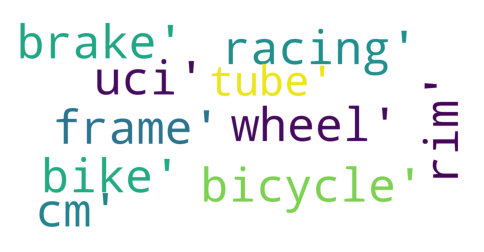

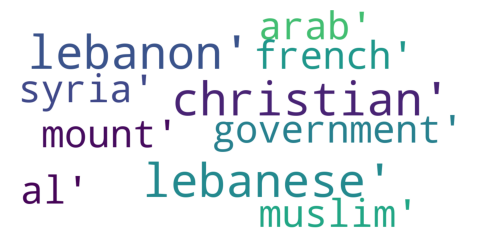

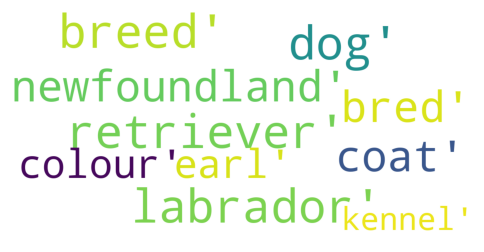

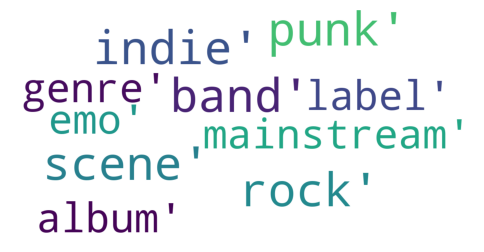

In [84]:
# Visualize topics with wordclouds
def show_wordcloud(topic, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(topic))

    fig = plt.figure(1, figsize=(6, 6))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

# Show wordclouds for each topic
for i in range(n_topics):
    show_wordcloud(dict(model_topics[i][1]))